# 21_optimization_figures ? CRAB + Adam diagnostics


Loads saved CRAB + Adam artifacts from 
`results/20_adam_crab_comperisson/` and produces reproducible figures and data dumps for comparison. The notebook performs no optimization; it reuses stored pulses, histories, and metadata.


In [1]:
import json
import math
from pathlib import Path
from typing import Dict

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (required for 3D projection)

from qoc_common_crab import load_baseline_crab
from qoc_common import terminal_cost_and_grad, forward_rhos
from crab_notebook_utils import (
    ensure_dir,
    json_ready,
    collect_versions,
    assert_finite,
    penalty_terms,
    ground_state_projectors,
    bloch_coordinates,
    population_excited,
)

plt.rcParams.update({"figure.dpi": 110})
NOTEBOOK_NAME = "21_optimization_figures.ipynb"


In [2]:
RESULTS_DIR = Path("results/20_adam_crab_comperisson")
if not RESULTS_DIR.exists():
    raise FileNotFoundError(f"Results directory not found: {RESULTS_DIR}")
CONFIG = json.loads((RESULTS_DIR / "config.json").read_text())
FIG_DIR = ensure_dir(Path(CONFIG["paths"]["figures"]))
pulses_npz = np.load(RESULTS_DIR / "pulses.npz")
t = pulses_npz["t"]
dt = float(CONFIG["time_grid"]["dt_us"])
T = float(CONFIG["time_grid"]["T_us"])
arrays, _ = load_baseline_crab("outputs/_baseline_crab")
rho0 = arrays["rho0"]
target = arrays["target"]
ensemble_beta_grid = np.asarray(CONFIG["ensemble"]["beta_grid"], dtype=float)
ensemble_doppler_grid = np.asarray(CONFIG["ensemble"]["doppler_grid"], dtype=float)
scale_grid = np.linspace(0.1, 6.0, 51)
delta_max = float(np.max(np.abs(pulses_npz["delta_original"])))
heatmap_doppler_grid = np.linspace(-delta_max, delta_max, 51)
OMEGA_SERIES = {
    "original": pulses_npz["omega_original"],
    "terminal": pulses_npz["omega_terminal"],
    "ensemble": pulses_npz["omega_ensemble"],
    "adiabatic": pulses_npz["omega_adiabatic"],
}
DELTA_SERIES = {
    "original": pulses_npz["delta_original"],
    "terminal": pulses_npz["delta_terminal"],
    "ensemble": pulses_npz["delta_ensemble"],
    "adiabatic": pulses_npz["delta_adiabatic"],
}
MODE_ORDER = ['original', 'terminal', 'ensemble', 'adiabatic']
COLOR_MAP = {
    'original': '#1f77b4',
    'terminal': '#ff7f0e',
    'ensemble': '#2ca02c',
    'adiabatic': '#d62728',
}
LABEL_MAP = {
    'original': 'Original',
    'terminal': 'Terminal (CRAB+Adam)',
    'ensemble': 'Ensemble (CRAB+Adam)',
    'adiabatic': 'Adiabatic (CRAB+Adam)',
}
legacy_histories_detected = False
MODE_HISTORIES: Dict[str, Dict[str, np.ndarray]] = {}
MODE_METADATA: Dict[str, Dict[str, object]] = {}
for mode in ('terminal', 'ensemble', 'adiabatic'):
    history_npz = np.load(RESULTS_DIR / f"mode_{mode}_history.npz")
    history = {key: np.asarray(history_npz[key]) for key in history_npz.files}
    # Backwards compatibility with earlier naming
    if 'infidelity' in history and 'final_infidelity' not in history:
        value = history.pop('infidelity')
        if mode == 'ensemble':
            history['mean_final_infidelity'] = value
        else:
            history['final_infidelity'] = value
        legacy_histories_detected = True
    if 'fidelity' in history:
        value = history.pop('fidelity')
        if mode == 'ensemble':
            history['mean_final_fidelity'] = value
        else:
            history['final_fidelity'] = value
        legacy_histories_detected = True
    if 'fidelity_mean' in history and 'mean_final_fidelity' not in history:
        history['mean_final_fidelity'] = history.pop('fidelity_mean')
        legacy_histories_detected = True
    if 'fidelity_std' in history and 'std_final_fidelity' not in history:
        history['std_final_fidelity'] = history.pop('fidelity_std')
        legacy_histories_detected = True
    if mode == 'ensemble' and 'mean_final_infidelity' not in history and 'mean_final_fidelity' in history:
        history['mean_final_infidelity'] = 1.0 - history['mean_final_fidelity']
    MODE_HISTORIES[mode] = history
    MODE_METADATA[mode] = json.loads((RESULTS_DIR / f"mode_{mode}_metadata.json").read_text())
print(f"Loaded artifacts for modes: {', '.join(MODE_HISTORIES.keys())}")
if legacy_histories_detected:
    print('Legacy history files detected; rerun 20_adam_crab_comperisson to refresh metrics.')


Loaded artifacts for modes: terminal, ensemble, adiabatic


In [3]:
def normalize_to_pi(omega: np.ndarray) -> np.ndarray:
    area = float(np.sum(omega, dtype=float) * dt)
    if math.isclose(area, 0.0, abs_tol=1e-12):
        return omega.astype(float, copy=True)
    return omega * (math.pi / area)
def terminal_infidelity(omega: np.ndarray, delta: np.ndarray) -> float:
    cost, _, _ = terminal_cost_and_grad(
        omega,
        delta,
        rho0,
        dt,
        target,
        power_weight=0.0,
        neg_weight=0.0,
    )
    return float(cost)
def compute_heatmap(omega: np.ndarray, delta: np.ndarray) -> np.ndarray:
    omega_norm = normalize_to_pi(omega)
    heat = np.empty((scale_grid.size, heatmap_doppler_grid.size), dtype=float)
    for i, scale in enumerate(scale_grid):
        omega_scaled = scale * omega_norm
        for j, doppler in enumerate(heatmap_doppler_grid):
            infidelity = terminal_infidelity(omega_scaled, delta + doppler)
            heat[i, j] = max(infidelity, 1e-12)
    return heat
def compute_population(omega: np.ndarray, delta: np.ndarray) -> np.ndarray:
    rhos = forward_rhos(omega, delta, rho0, dt)
    return population_excited(rhos)
def compute_bloch_paths(omega: np.ndarray, delta: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    rhos = forward_rhos(omega, delta, rho0, dt)
    state_coords = bloch_coordinates(rhos)
    gs_projectors = ground_state_projectors(omega, delta)
    gs_coords = bloch_coordinates(gs_projectors)
    return state_coords, gs_coords
def save_figure(fig: plt.Figure, stem: str, data: dict | None = None) -> None:
    png_dir = ensure_dir(FIG_DIR / 'png')
    pdf_dir = ensure_dir(FIG_DIR / 'pdf')
    data_dir = ensure_dir(FIG_DIR / 'data')
    png_path = png_dir / f"{stem}.png"
    pdf_path = pdf_dir / f"{stem}.pdf"
    fig.savefig(png_path, dpi=300)
    fig.savefig(pdf_path)
    if data is not None:
        np.savez_compressed(data_dir / f"{stem}_data.npz", **data)
    print(f"Saved figure '{stem}' to {png_path}")


Saved figure 'omega_pulses' to figures\21_optimization_figures\png\omega_pulses.png


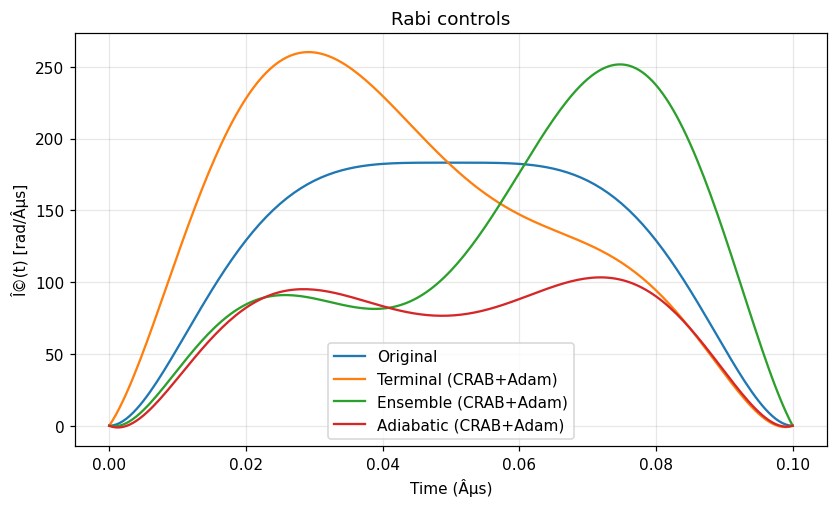

In [4]:
fig, ax = plt.subplots(figsize=(7.5, 4.5), layout='constrained')
for name in MODE_ORDER:
    omega = OMEGA_SERIES[name]
    ax.plot(t, omega, label=LABEL_MAP[name], color=COLOR_MAP[name])
ax.set_xlabel('Time (Âµs)')
ax.set_ylabel('Î©(t) [rad/Âµs]')
ax.set_title('Rabi controls')
ax.legend()
ax.grid(True, alpha=0.3)
save_figure(fig, 'omega_pulses', data={**{f'omega_{k}': v for k, v in OMEGA_SERIES.items()}, 't': t})


Saved figure 'delta_pulses' to figures\21_optimization_figures\png\delta_pulses.png


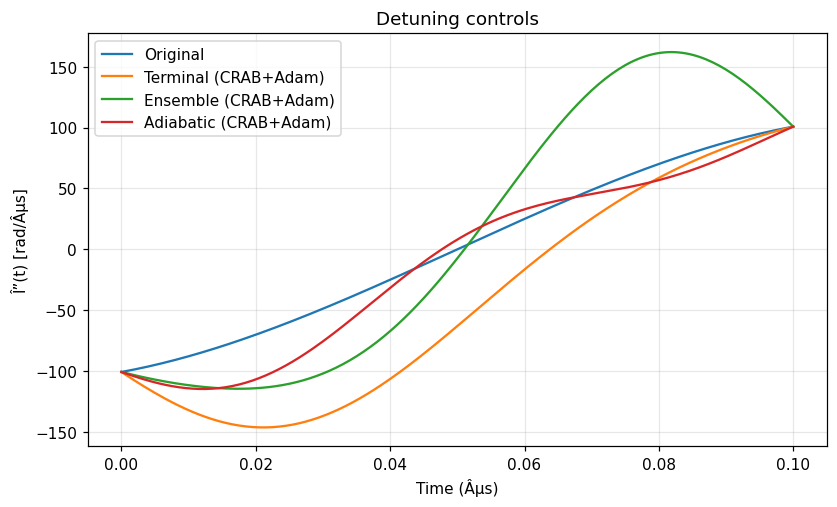

In [5]:
fig, ax = plt.subplots(figsize=(7.5, 4.5), layout='constrained')
for name in MODE_ORDER:
    delta = DELTA_SERIES[name]
    ax.plot(t, delta, label=LABEL_MAP[name], color=COLOR_MAP[name])
ax.set_xlabel('Time (Âµs)')
ax.set_ylabel('Î”(t) [rad/Âµs]')
ax.set_title('Detuning controls')
ax.legend()
ax.grid(True, alpha=0.3)
save_figure(fig, 'delta_pulses', data={**{f'delta_{k}': v for k, v in DELTA_SERIES.items()}, 't': t})


Saved figure 'population_dynamics' to figures\21_optimization_figures\png\population_dynamics.png


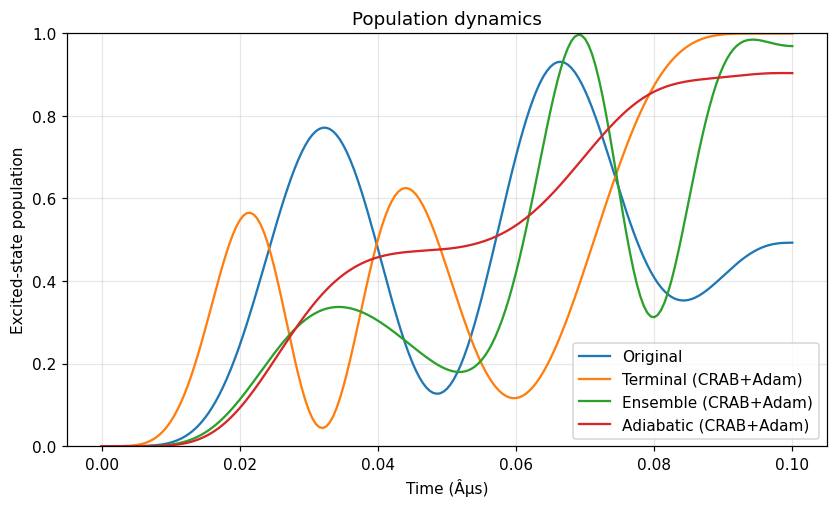

In [6]:
population_traces = {}
for name in MODE_ORDER:
    population_traces[name] = compute_population(OMEGA_SERIES[name], DELTA_SERIES[name])

fig, ax = plt.subplots(figsize=(7.5, 4.5), layout='constrained')
for name in MODE_ORDER:
    pop = population_traces[name]
    ax.plot(t, pop, label=LABEL_MAP[name], color=COLOR_MAP[name])
ax.set_xlabel('Time (Âµs)')
ax.set_ylabel('Excited-state population')
ax.set_ylim(0.0, 1.0)
ax.set_title('Population dynamics')
ax.legend()
ax.grid(True, alpha=0.3)
save_figure(fig, 'population_dynamics', data={**population_traces, 't': t})


Saved figure 'infidelity_heatmaps' to figures\21_optimization_figures\png\infidelity_heatmaps.png


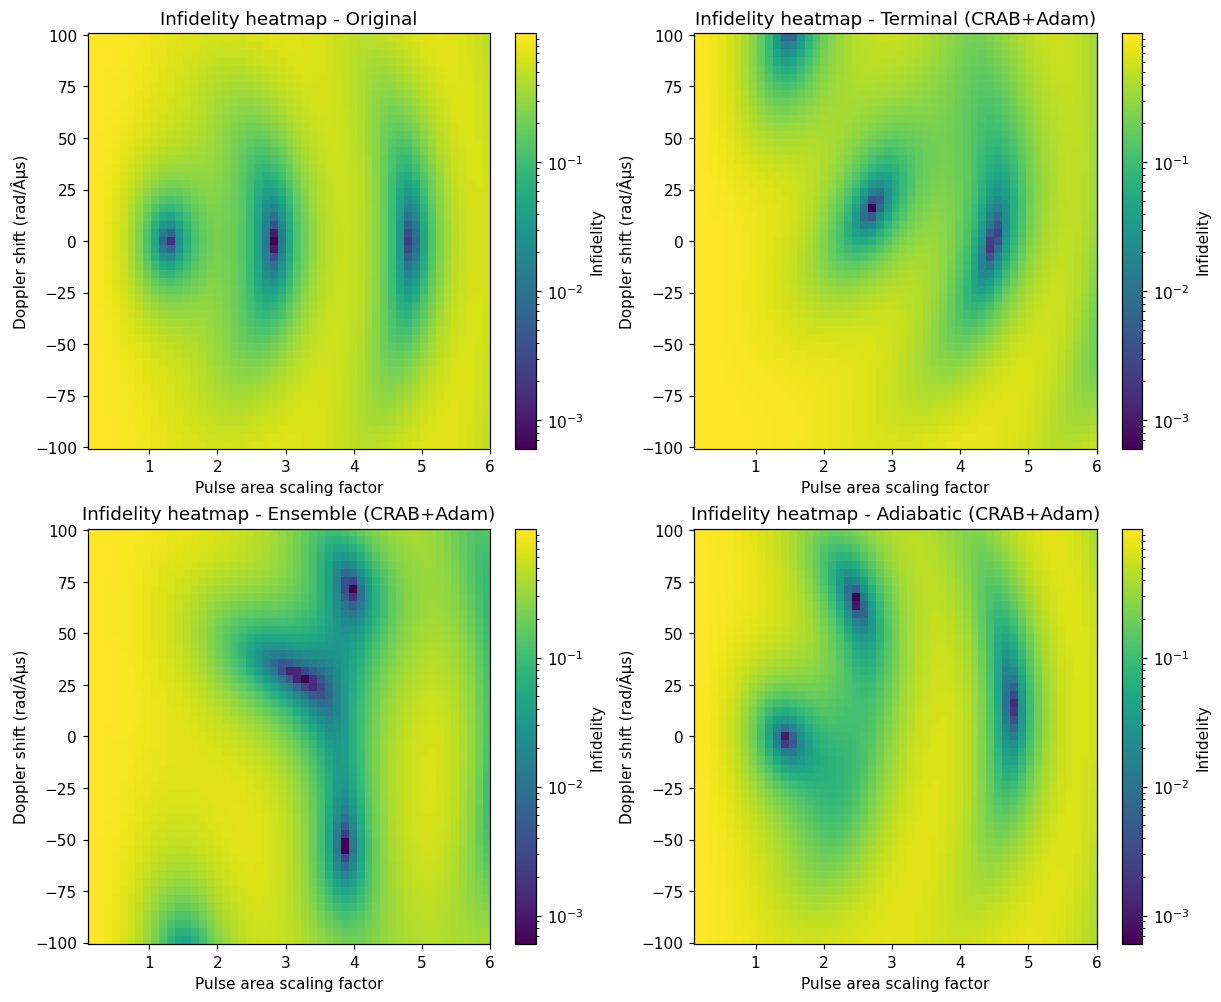

In [12]:
heatmaps = {}
vmin = 1e-8
vmax = 1e-8
for name in MODE_ORDER:
    heatmaps[name] = compute_heatmap(OMEGA_SERIES[name], DELTA_SERIES[name])
    heat = heatmaps[name]
    vmin = max(np.min(heat), vmin)
    vmax = max(np.max(heat), vmax)
fig, axes = plt.subplots(2, 2, figsize=(11, 9), layout='constrained')
for ax, name in zip(axes.flat, MODE_ORDER):
    heat = heatmaps[name]
    im = ax.imshow(
        heat.T,
        origin='lower',
        aspect='auto',
        extent=[scale_grid[0], scale_grid[-1], heatmap_doppler_grid[0], heatmap_doppler_grid[-1]],
        norm=LogNorm(vmin=vmin, vmax=vmax),
        cmap='viridis',
    )
    ax.set_title(f"Infidelity heatmap - {LABEL_MAP[name]}")
    ax.set_xlabel('Pulse area scaling factor')
    ax.set_ylabel('Doppler shift (rad/Âµs)')
    fig.colorbar(im, ax=ax, label='Infidelity')
save_figure(fig, 'infidelity_heatmaps', data={**{f'heatmap_{k}': v for k, v in heatmaps.items()}, 'scale_grid': scale_grid, 'heatmap_doppler_grid': heatmap_doppler_grid})


Saved figure 'cost_convergence' to figures\21_optimization_figures\png\cost_convergence.png


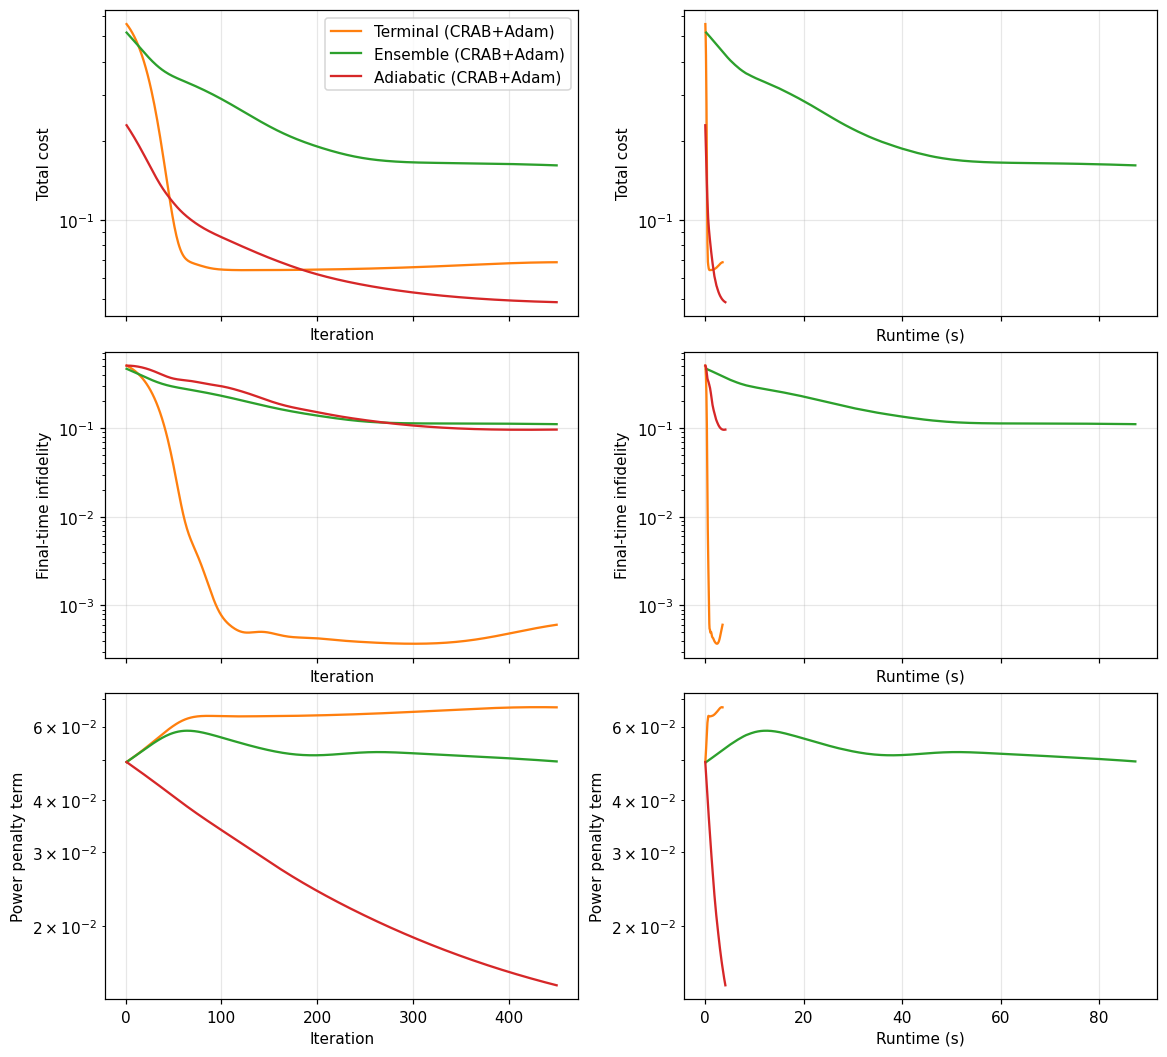

In [8]:
fig, axes = plt.subplots(3, 2, figsize=(10.5, 9.5), sharex='col', layout='constrained')
row_labels = ['Total cost', 'Final-time infidelity', 'Power penalty term']
infidelity_key = {
    'terminal': 'final_infidelity',
    'ensemble': 'mean_final_infidelity',
    'adiabatic': 'final_infidelity',
}
mode_iter_list = ['terminal', 'ensemble', 'adiabatic']
for row_idx, row_label in enumerate(row_labels):
    for col_idx, axis in enumerate(axes[row_idx]):
        for mode in mode_iter_list:
            history = MODE_HISTORIES[mode]
            if row_idx == 0:
                values = history['cost']
            elif row_idx == 1:
                key = infidelity_key[mode]
                values = history[key]
            else:
                values = history['power_penalty']
            values = np.asarray(values, dtype=float)
            values = np.clip(values, 1e-14, None)
            if col_idx == 0:
                axis.semilogy(history['iteration'], values, label=LABEL_MAP[mode], color=COLOR_MAP[mode])
                axis.set_xlabel('Iteration')
            else:
                runtime = np.cumsum(history['runtime_s'])
                axis.semilogy(runtime, values, label=LABEL_MAP[mode], color=COLOR_MAP[mode])
                axis.set_xlabel('Runtime (s)')
        axis.set_ylabel(row_label)
        axis.grid(True, alpha=0.3)
axes[0, 0].legend(loc='upper right')
save_figure(
    fig,
    'cost_convergence',
    data={f'{mode}_{key}': MODE_HISTORIES[mode][key] for mode in MODE_HISTORIES for key in MODE_HISTORIES[mode]},
)


Saved figure 'bloch_trajectories' to figures\21_optimization_figures\png\bloch_trajectories.png


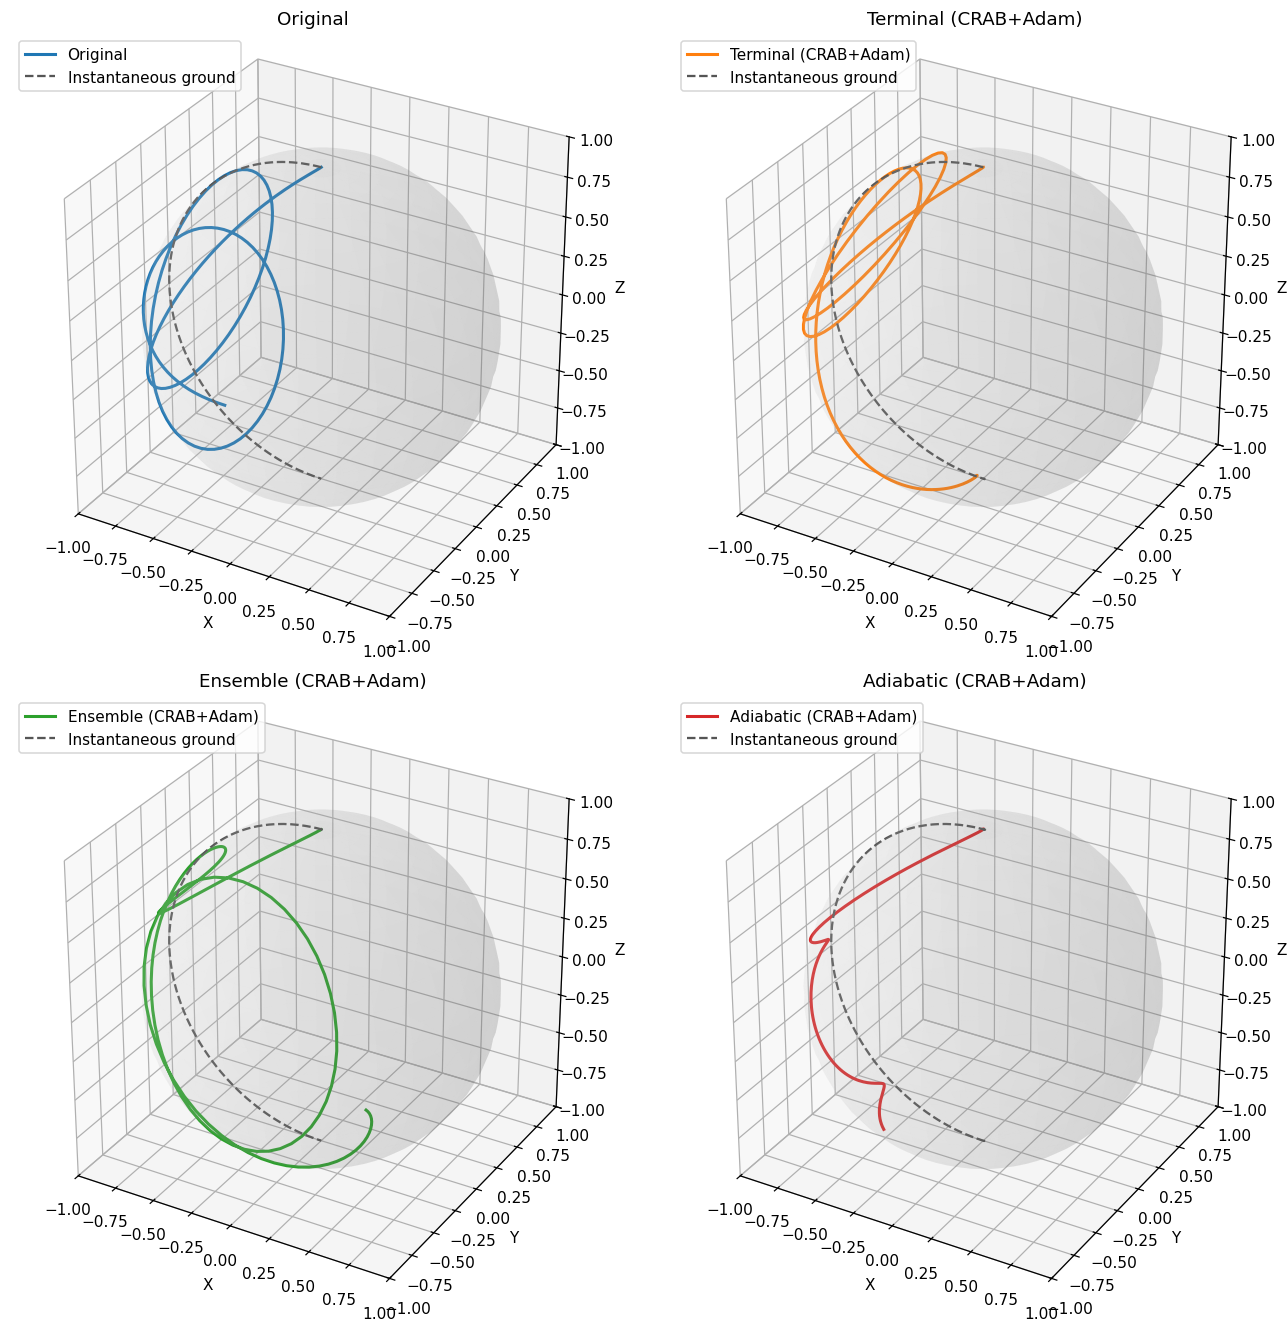

In [9]:
bloch_paths = {name: compute_bloch_paths(OMEGA_SERIES[name], DELTA_SERIES[name]) for name in MODE_ORDER}
fig = plt.figure(figsize=(12, 12), layout='constrained')
mode_order = MODE_ORDER
for idx, name in enumerate(mode_order):
    ax = fig.add_subplot(2, 2, idx + 1, projection='3d')
    state_coords, gs_coords = bloch_paths[name]
    u = np.linspace(0, 2 * np.pi, 60)
    v = np.linspace(0, np.pi, 30)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones_like(u), np.cos(v))
    ax.plot_surface(x, y, z, color='lightgray', alpha=0.1, linewidth=0, zorder=0)
    ax.plot(state_coords[:, 0], state_coords[:, 1], state_coords[:, 2], label=LABEL_MAP[name], lw=2, color=COLOR_MAP[name])
    ax.plot(gs_coords[:, 0], gs_coords[:, 1], gs_coords[:, 2], label='Instantaneous ground', lw=1.5, linestyle='--', color='#555555')
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_box_aspect([1, 1, 1])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(LABEL_MAP[name])
    ax.legend(loc='upper left')
bloch_data = {f'state_{k}': bloch_paths[k][0] for k in bloch_paths}
bloch_data.update({f'ground_{k}': bloch_paths[k][1] for k in bloch_paths})
save_figure(fig, 'bloch_trajectories', data=bloch_data)


In [10]:
print('Figures saved to', FIG_DIR)
for item in sorted(FIG_DIR.iterdir()):
    print('  ', item.name)


Figures saved to figures\21_optimization_figures
   data
   pdf
   png
